In [42]:
from utils.util import file_reader, data_preparation, shuffle_dataset, column_transformation, plot_metrics
from models.model import model_a, model_b, model_c, model_d, model_e
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import copy
import numpy as np
print("GPU Available: ", tf.test.is_gpu_available())
import warnings
warnings.filterwarnings('ignore')

GPU Available:  False


In [20]:
training_data = file_reader()
print(training_data.shape)

(257673, 45)


In [21]:
training_data['label'].value_counts()

label
1    164673
0     93000
Name: count, dtype: int64

In [22]:
training_data = training_data[['dur','proto','service','state','spkts','sbytes','sttl','sload','swin','synack','ackdat','label']]

training_data['service'].value_counts()

training_data = training_data[training_data.service != '-']

In [23]:
training_data['label'].value_counts()

label
1    87239
0    29113
Name: count, dtype: int64

In [24]:
zeros, ones = np.bincount(training_data['label'])
total = zeros + ones
print('Examples:\n    Total: {}\n    ONES: {} ({:.2f}% of total)\n'.format(
    total, ones, 100 * ones / total))

print('Examples:\n    Total: {}\n    ZEROS: {} ({:.2f}% of total)\n'.format(
    total, zeros, 100 * zeros / total))

Examples:
    Total: 116352
    ONES: 87239 (74.98% of total)

Examples:
    Total: 116352
    ZEROS: 29113 (25.02% of total)



In [25]:
initial_bias = np.log([zeros/ones])
initial_bias

array([-1.09746667])

In [26]:
training_feature_data = copy.deepcopy(training_data)
training_data_features, data_labels= data_preparation(training_feature_data)
feature_columns = column_transformation(training_data_features,training_feature_data)
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [27]:
batch_size = 32
train, test = train_test_split(training_data, test_size=0.2,stratify = training_data['label'])
train, val = train_test_split(train, test_size=0.2,stratify = train['label'])
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

train_data_features,train_data_labels = data_preparation(train)
train_dataset = shuffle_dataset(train_data_features,train_data_labels,batch_size)


test_data_features,test_data_labels = data_preparation(test)
test_dataset = shuffle_dataset(test_data_features,test_data_labels,batch_size)

val_data_features,val_data_labels = data_preparation(val)
val_dataset = shuffle_dataset(val_data_features,val_data_labels,batch_size)

74464 train examples
18617 validation examples
23271 test examples


In [28]:
model_a1 = model_a(feature_layer,initial_bias)
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96)


METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),# same as model's loss
      tf.keras.metrics.TruePositives(name='TP'),
      tf.keras.metrics.FalsePositives(name='FP'),
      tf.keras.metrics.TrueNegatives(name='TN'),
      tf.keras.metrics.FalseNegatives(name='FN'), 
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),
      tf.keras.metrics.AUC(name='AUC'),
      tf.keras.metrics.AUC(name='PRC', curve='PR'), # precision-recall curve
]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)


model_a1.compile(optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=METRICS)

history_a = model_a1.fit(train_dataset,
          validation_data=val_dataset,
          epochs=200,callbacks=[early_stopping])

Epoch 1/200
2327/2327 [==============================] - 18s 6ms/step - loss: 0.2124 - cross entropy: 0.1653 - TP: 54873.0000 - FP: 3269.0000 - TN: 15363.0000 - FN: 959.0000 - Precision: 0.9438 - Recall: 0.9828 - AUC: 0.9723 - PRC: 0.9896 - val_loss: 0.1496 - val_cross entropy: 0.1274 - val_TP: 13935.0000 - val_FP: 767.0000 - val_TN: 3891.0000 - val_FN: 24.0000 - val_Precision: 0.9478 - val_Recall: 0.9983 - val_AUC: 0.9844 - val_PRC: 0.9942
Epoch 2/200
2327/2327 [==============================] - 12s 5ms/step - loss: 0.1672 - cross entropy: 0.1437 - TP: 55333.0000 - FP: 3014.0000 - TN: 15618.0000 - FN: 499.0000 - Precision: 0.9483 - Recall: 0.9911 - AUC: 0.9757 - PRC: 0.9904 - val_loss: 0.1727 - val_cross entropy: 0.1553 - val_TP: 13937.0000 - val_FP: 767.0000 - val_TN: 3891.0000 - val_FN: 22.0000 - val_Precision: 0.9478 - val_Recall: 0.9984 - val_AUC: 0.9841 - val_PRC: 0.9943
Epoch 3/200
2327/2327 [==============================] - 12s 5ms/step - loss: 0.1643 - cross entropy: 0.1454 -

In [29]:
results = model_a1.evaluate(test_dataset)
print("Results: ", results)

728/728 [==============================] - 4s 5ms/step - loss: 0.0917 - cross entropy: 0.0875 - TP: 17421.0000 - FP: 874.0000 - TN: 4949.0000 - FN: 27.0000 - Precision: 0.9522 - Recall: 0.9985 - AUC: 0.9915 - PRC: 0.9971
Results:  [0.09174948930740356, 0.0874544233083725, 17421.0, 874.0, 4949.0, 27.0, 0.9522274136543274, 0.9984525442123413, 0.9914772510528564, 0.9970580339431763]


728/728 [==============================] - 3s 4ms/step
[[ 5728    95]
 [ 1912 15536]]


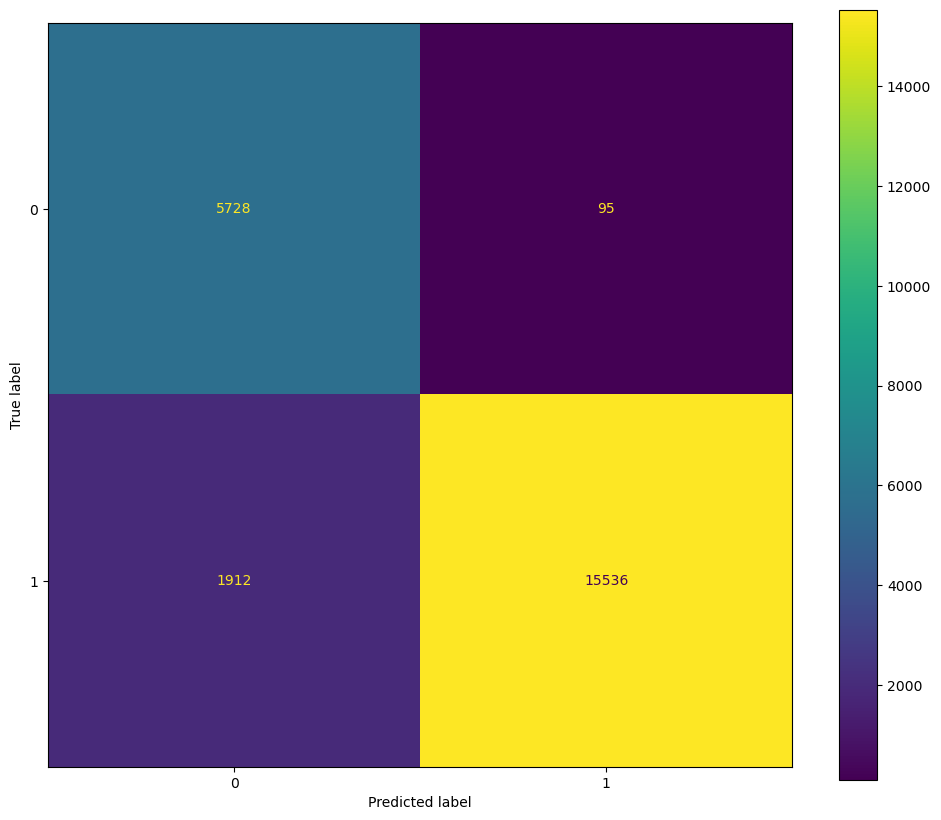

In [34]:
y_pred_a1  = model_a1.predict(test_dataset)
y_pred_val_a1 = [1 if (i > 0.9) else 0 for i in y_pred_a1 ]
cm = confusion_matrix(test_data_labels, y_pred_val_a1)
print(cm)
ConfusionMatrixDisplay(cm).plot()

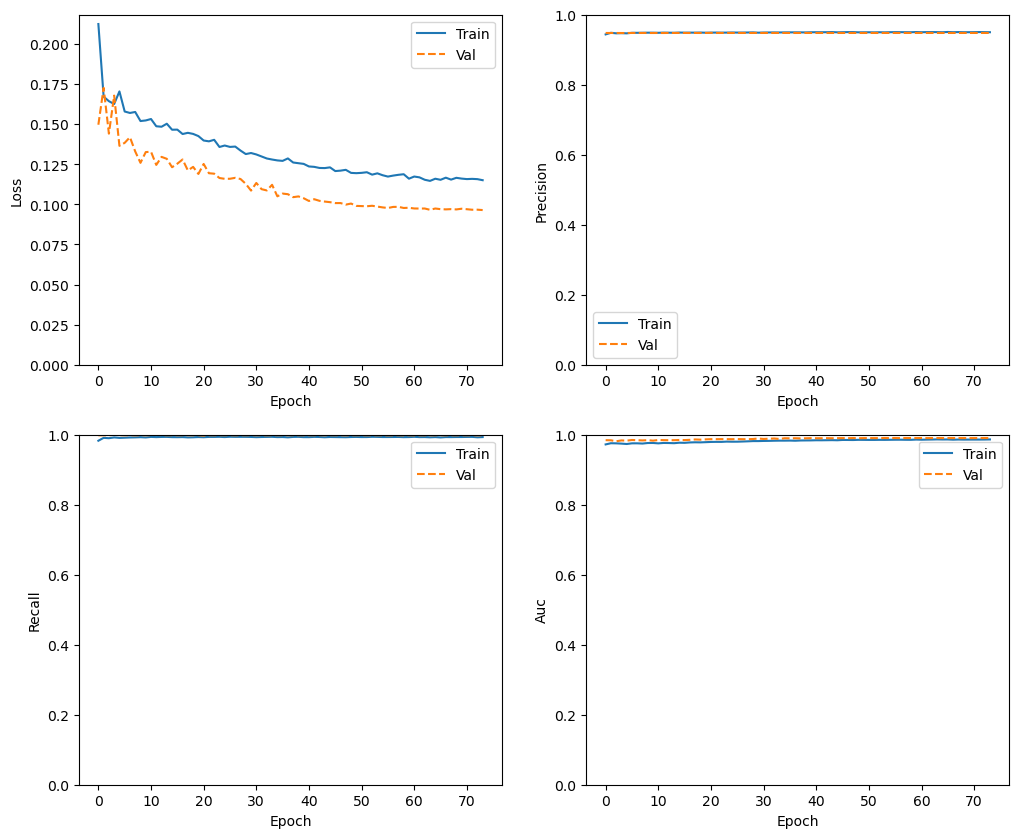

In [31]:
plot_metrics(history_a)

In [32]:
model_b1 = model_b(feature_layer,initial_bias)
initial_learning_rate = 0.01

METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),# same as model's loss
      tf.keras.metrics.TruePositives(name='TP'),
      tf.keras.metrics.FalsePositives(name='FP'),
      tf.keras.metrics.TrueNegatives(name='TN'),
      tf.keras.metrics.FalseNegatives(name='FN'), 
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),
      tf.keras.metrics.AUC(name='AUC'),
      tf.keras.metrics.AUC(name='PRC', curve='PR'), # precision-recall curve
]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)


model_b1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics= METRICS)

history_b = model_b1.fit(train_dataset,
          validation_data=val_dataset,
          epochs=200,callbacks=[early_stopping])

Epoch 1/200
2327/2327 [==============================] - 37s 13ms/step - loss: 0.2663 - cross entropy: 0.1716 - TP: 54861.0000 - FP: 3258.0000 - TN: 15374.0000 - FN: 971.0000 - Precision: 0.9439 - Recall: 0.9826 - AUC: 0.9667 - PRC: 0.9866 - val_loss: 0.1988 - val_cross entropy: 0.1229 - val_TP: 13939.0000 - val_FP: 767.0000 - val_TN: 3891.0000 - val_FN: 20.0000 - val_Precision: 0.9478 - val_Recall: 0.9986 - val_AUC: 0.9807 - val_PRC: 0.9931
Epoch 2/200
2327/2327 [==============================] - 26s 11ms/step - loss: 0.2377 - cross entropy: 0.1630 - TP: 55247.0000 - FP: 3150.0000 - TN: 15482.0000 - FN: 585.0000 - Precision: 0.9461 - Recall: 0.9895 - AUC: 0.9656 - PRC: 0.9852 - val_loss: 0.2509 - val_cross entropy: 0.1892 - val_TP: 13959.0000 - val_FP: 771.0000 - val_TN: 3887.0000 - val_FN: 0.0000e+00 - val_Precision: 0.9477 - val_Recall: 1.0000 - val_AUC: 0.9813 - val_PRC: 0.9933
Epoch 3/200
2327/2327 [==============================] - 26s 11ms/step - loss: 0.2322 - cross entropy: 0.

In [33]:
results = model_b1.evaluate(test_dataset)
print("Results: ", results)

728/728 [==============================] - 5s 6ms/step - loss: 0.1592 - cross entropy: 0.1190 - TP: 17438.0000 - FP: 876.0000 - TN: 4947.0000 - FN: 10.0000 - Precision: 0.9522 - Recall: 0.9994 - AUC: 0.9812 - PRC: 0.9928
Results:  [0.15922461450099945, 0.1189570426940918, 17438.0, 876.0, 4947.0, 10.0, 0.9521677494049072, 0.9994268417358398, 0.9811528325080872, 0.9928139448165894]


728/728 [==============================] - 5s 5ms/step
[[ 5778    45]
 [ 4233 13215]]


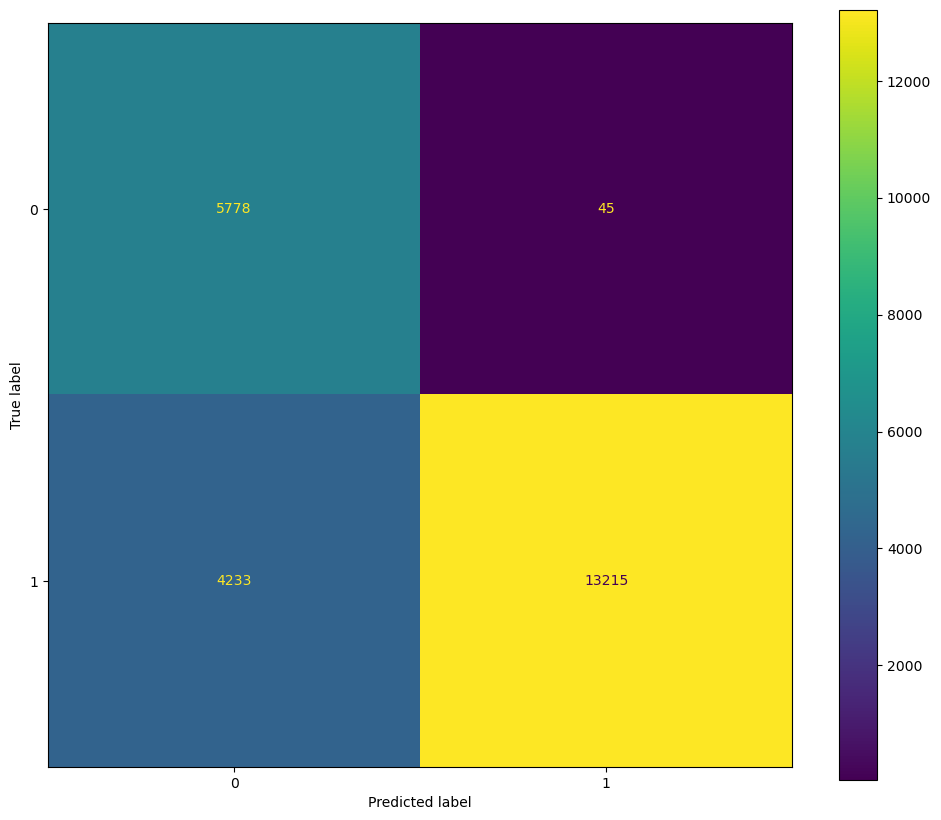

In [35]:
y_pred_b1  = model_b1.predict(test_dataset)
y_pred_val_b1 = [1 if (i > 0.9) else 0 for i in y_pred_b1 ]
cm = confusion_matrix(test_data_labels, y_pred_val_b1)
print(cm)
ConfusionMatrixDisplay(cm).plot()

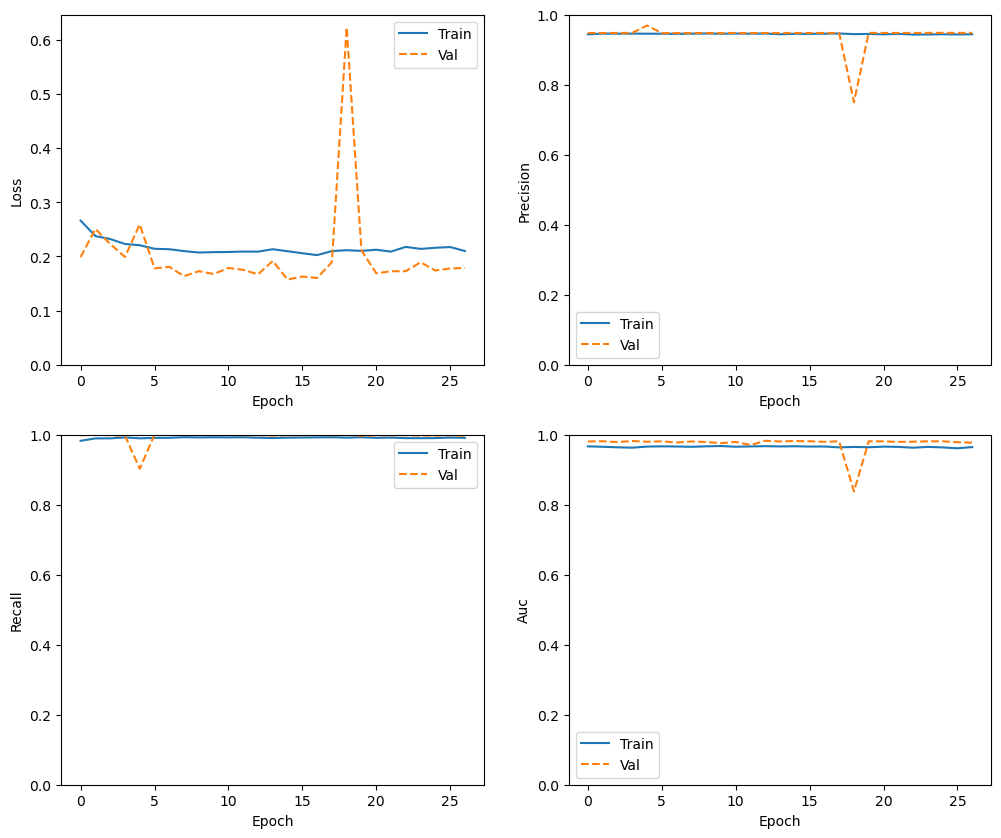

In [39]:
plot_metrics(history_b)

In [36]:
model_c1 = model_c(feature_layer,initial_bias)


METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),# same as model's loss
      tf.keras.metrics.TruePositives(name='TP'),
      tf.keras.metrics.FalsePositives(name='FP'),
      tf.keras.metrics.TrueNegatives(name='TN'),
      tf.keras.metrics.FalseNegatives(name='FN'), 
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),
      tf.keras.metrics.AUC(name='AUC'),
      tf.keras.metrics.AUC(name='PRC', curve='PR'), # precision-recall curve
]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)


model_c1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=METRICS)

history_c = model_c1.fit(train_dataset,
          validation_data=val_dataset,
          epochs=200,callbacks=[early_stopping])

Epoch 1/200
2327/2327 [==============================] - 31s 10ms/step - loss: 0.4845 - cross entropy: 0.1930 - TP: 53487.0000 - FP: 3166.0000 - TN: 15466.0000 - FN: 2345.0000 - Precision: 0.9441 - Recall: 0.9580 - AUC: 0.9679 - PRC: 0.9878 - val_loss: 0.1437 - val_cross entropy: 0.0995 - val_TP: 13936.0000 - val_FP: 765.0000 - val_TN: 3893.0000 - val_FN: 23.0000 - val_Precision: 0.9480 - val_Recall: 0.9984 - val_AUC: 0.9905 - val_PRC: 0.9968
Epoch 2/200
2327/2327 [==============================] - 22s 9ms/step - loss: 0.1480 - cross entropy: 0.1194 - TP: 55015.0000 - FP: 2780.0000 - TN: 15852.0000 - FN: 817.0000 - Precision: 0.9519 - Recall: 0.9854 - AUC: 0.9856 - PRC: 0.9944 - val_loss: 0.1177 - val_cross entropy: 0.0973 - val_TP: 13937.0000 - val_FP: 767.0000 - val_TN: 3891.0000 - val_FN: 22.0000 - val_Precision: 0.9478 - val_Recall: 0.9984 - val_AUC: 0.9911 - val_PRC: 0.9969
Epoch 3/200
2327/2327 [==============================] - 22s 9ms/step - loss: 0.1353 - cross entropy: 0.1162

In [37]:
results = model_c1.evaluate(test_dataset)
print("Results: ", results)

728/728 [==============================] - 4s 6ms/step - loss: 0.0979 - cross entropy: 0.0868 - TP: 17440.0000 - FP: 874.0000 - TN: 4949.0000 - FN: 8.0000 - Precision: 0.9523 - Recall: 0.9995 - AUC: 0.9919 - PRC: 0.9971
Results:  [0.0979120284318924, 0.08680984377861023, 17440.0, 874.0, 4949.0, 8.0, 0.9522769451141357, 0.9995415210723877, 0.9919103980064392, 0.9970983862876892]


728/728 [==============================] - 5s 5ms/step
[[ 5767    56]
 [ 2464 14984]]


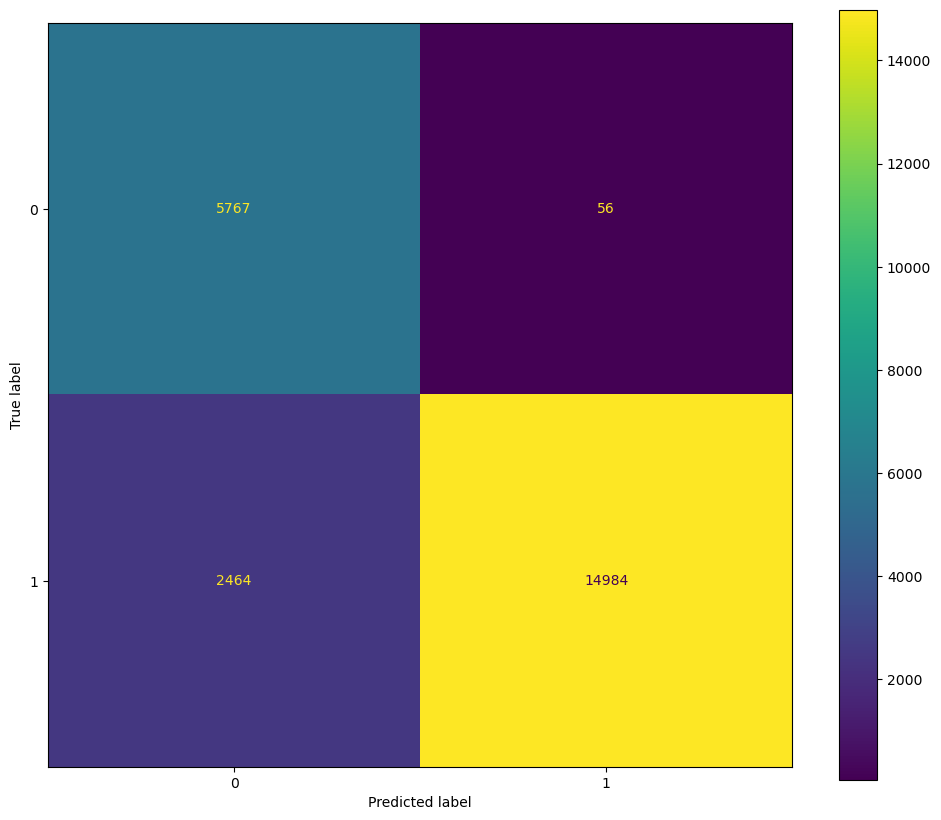

In [38]:
y_pred_c1  = model_c1.predict(test_dataset)
y_pred_val_c1 = [1 if (i > 0.9) else 0 for i in y_pred_c1 ]
cm = confusion_matrix(test_data_labels, y_pred_val_c1)
print(cm)
ConfusionMatrixDisplay(cm).plot()

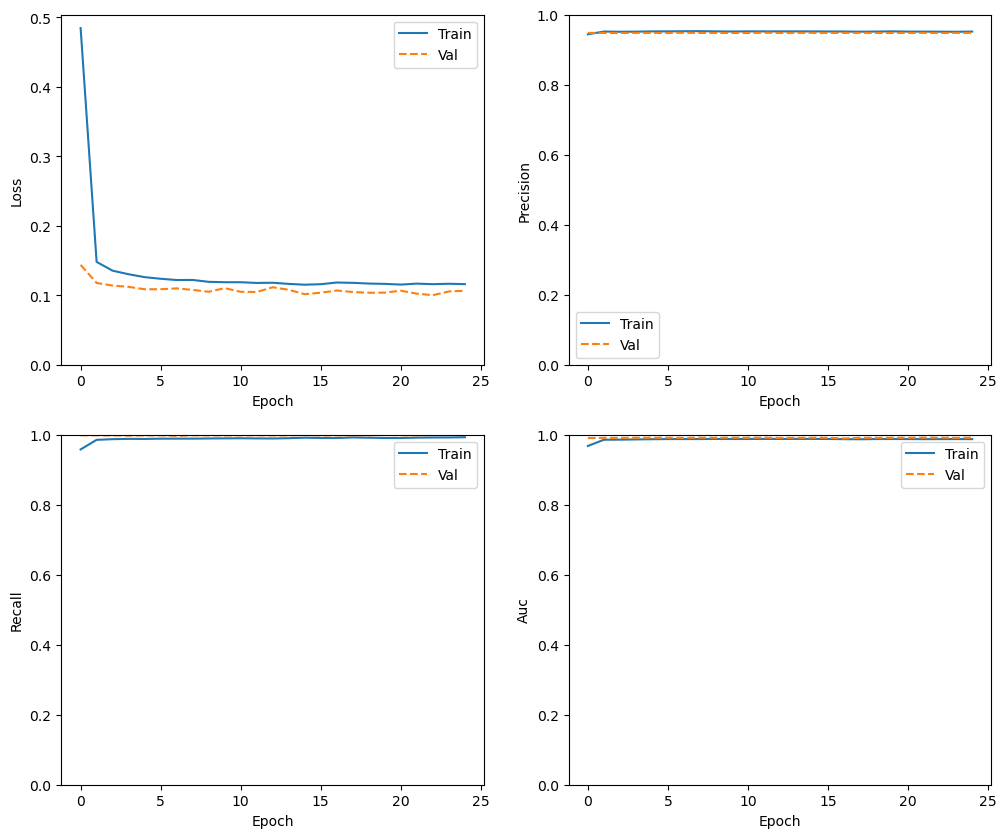

In [40]:
plot_metrics(history_c)

In [44]:
model_d1 = model_d(feature_layer,initial_bias)

initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96)

METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),# same as model's loss
      tf.keras.metrics.TruePositives(name='TP'),
      tf.keras.metrics.FalsePositives(name='FP'),
      tf.keras.metrics.TrueNegatives(name='TN'),
      tf.keras.metrics.FalseNegatives(name='FN'), 
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),
      tf.keras.metrics.AUC(name='AUC'),
      tf.keras.metrics.AUC(name='PRC', curve='PR'), # precision-recall curve
]

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

model_d1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics= METRICS)

history_d = model_d1.fit(train_dataset,
          validation_data=val_dataset,
          epochs=200,callbacks=[early_stopping,tensorboard_callback])

Epoch 1/200
2327/2327 [==============================] - 42s 13ms/step - loss: 0.9585 - cross entropy: 0.2857 - TP: 54098.0000 - FP: 4846.0000 - TN: 13786.0000 - FN: 1734.0000 - Precision: 0.9178 - Recall: 0.9689 - AUC: 0.9065 - PRC: 0.9463 - val_loss: 0.7097 - val_cross entropy: 0.1965 - val_TP: 13887.0000 - val_FP: 766.0000 - val_TN: 3892.0000 - val_FN: 72.0000 - val_Precision: 0.9477 - val_Recall: 0.9948 - val_AUC: 0.8642 - val_PRC: 0.8958
Epoch 2/200
2327/2327 [==============================] - 24s 10ms/step - loss: 0.8000 - cross entropy: 0.2803 - TP: 54204.0000 - FP: 4729.0000 - TN: 13903.0000 - FN: 1628.0000 - Precision: 0.9198 - Recall: 0.9708 - AUC: 0.9092 - PRC: 0.9474 - val_loss: 1.2859 - val_cross entropy: 0.7648 - val_TP: 13959.0000 - val_FP: 4658.0000 - val_TN: 0.0000e+00 - val_FN: 0.0000e+00 - val_Precision: 0.7498 - val_Recall: 1.0000 - val_AUC: 0.9300 - val_PRC: 0.9634
Epoch 3/200
2327/2327 [==============================] - 29s 12ms/step - loss: 0.8074 - cross entropy

In [45]:
results = model_d1.evaluate(test_dataset)
print("Results: ", results)

728/728 [==============================] - 4s 6ms/step - loss: 0.3555 - cross entropy: 0.1609 - TP: 17346.0000 - FP: 858.0000 - TN: 4965.0000 - FN: 102.0000 - Precision: 0.9529 - Recall: 0.9942 - AUC: 0.9206 - PRC: 0.9403
Results:  [0.3554510772228241, 0.16092842817306519, 17346.0, 858.0, 4965.0, 102.0, 0.9528675079345703, 0.9941540360450745, 0.9206289649009705, 0.9403116106987]


728/728 [==============================] - 4s 5ms/step
[[ 4987   836]
 [  392 17056]]


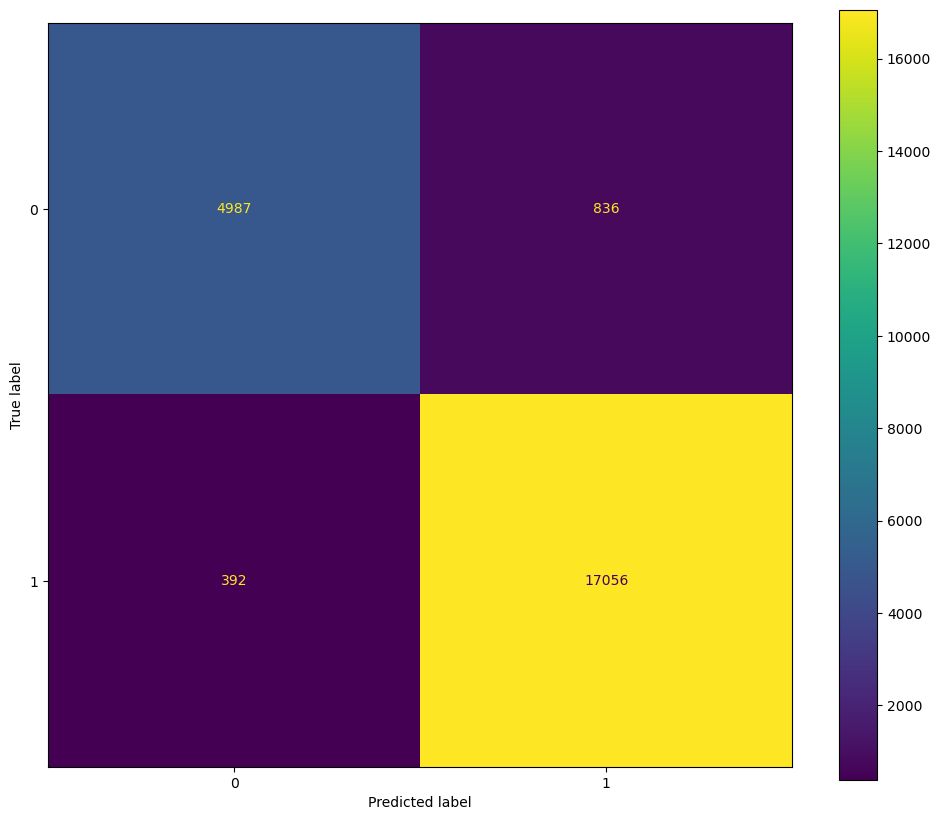

In [46]:
y_pred_d1  = model_d1.predict(test_dataset)
y_pred_val_d1 = [1 if (i > 0.9) else 0 for i in y_pred_d1 ]
cm = confusion_matrix(test_data_labels, y_pred_val_d1)
print(cm)
ConfusionMatrixDisplay(cm).plot()

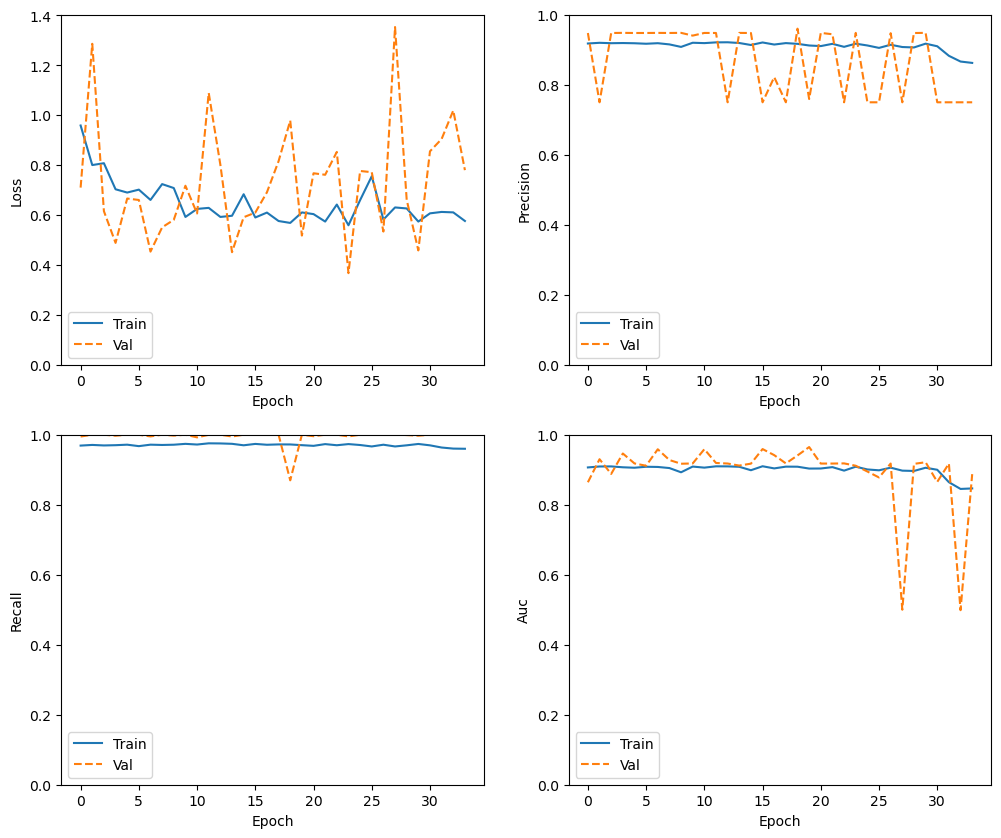

In [47]:
plot_metrics(history_d)

In [49]:
model_e1 = model_e(feature_layer,initial_bias)
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96)


METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),# same as model's loss
      tf.keras.metrics.TruePositives(name='TP'),
      tf.keras.metrics.FalsePositives(name='FP'),
      tf.keras.metrics.TrueNegatives(name='TN'),
      tf.keras.metrics.FalseNegatives(name='FN'), 
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),
      tf.keras.metrics.AUC(name='AUC'),
      tf.keras.metrics.AUC(name='PRC', curve='PR'), # precision-recall curve
]

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=30,
    mode='min',
    restore_best_weights=True)

model_e1.compile(optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=METRICS)

history_e = model_e1.fit(train_dataset,
          validation_data=val_dataset,
          epochs=200,callbacks=[early_stopping,tensorboard_callback])

Epoch 1/200
2327/2327 [==============================] - 32s 10ms/step - loss: 0.3643 - cross entropy: 0.1759 - TP: 54526.0000 - FP: 3266.0000 - TN: 15366.0000 - FN: 1306.0000 - Precision: 0.9435 - Recall: 0.9766 - AUC: 0.9698 - PRC: 0.9886 - val_loss: 0.1598 - val_cross entropy: 0.1329 - val_TP: 13883.0000 - val_FP: 767.0000 - val_TN: 3891.0000 - val_FN: 76.0000 - val_Precision: 0.9476 - val_Recall: 0.9946 - val_AUC: 0.9839 - val_PRC: 0.9944
Epoch 2/200
2327/2327 [==============================] - 22s 9ms/step - loss: 0.1774 - cross entropy: 0.1464 - TP: 55212.0000 - FP: 3081.0000 - TN: 15551.0000 - FN: 620.0000 - Precision: 0.9471 - Recall: 0.9889 - AUC: 0.9765 - PRC: 0.9911 - val_loss: 0.1489 - val_cross entropy: 0.1263 - val_TP: 13935.0000 - val_FP: 767.0000 - val_TN: 3891.0000 - val_FN: 24.0000 - val_Precision: 0.9478 - val_Recall: 0.9983 - val_AUC: 0.9822 - val_PRC: 0.9932
Epoch 3/200
2327/2327 [==============================] - 22s 9ms/step - loss: 0.1656 - cross entropy: 0.1424

In [50]:
results = model_e1.evaluate(test_dataset)
print("Results: ", results)

728/728 [==============================] - 4s 6ms/step - loss: 0.1437 - cross entropy: 0.1197 - TP: 17422.0000 - FP: 876.0000 - TN: 4947.0000 - FN: 26.0000 - Precision: 0.9521 - Recall: 0.9985 - AUC: 0.9846 - PRC: 0.9945
Results:  [0.14369916915893555, 0.11968477070331573, 17422.0, 876.0, 4947.0, 26.0, 0.9521259069442749, 0.9985098838806152, 0.9845550060272217, 0.9945015907287598]


728/728 [==============================] - 4s 4ms/step
[[ 4959   864]
 [   50 17398]]


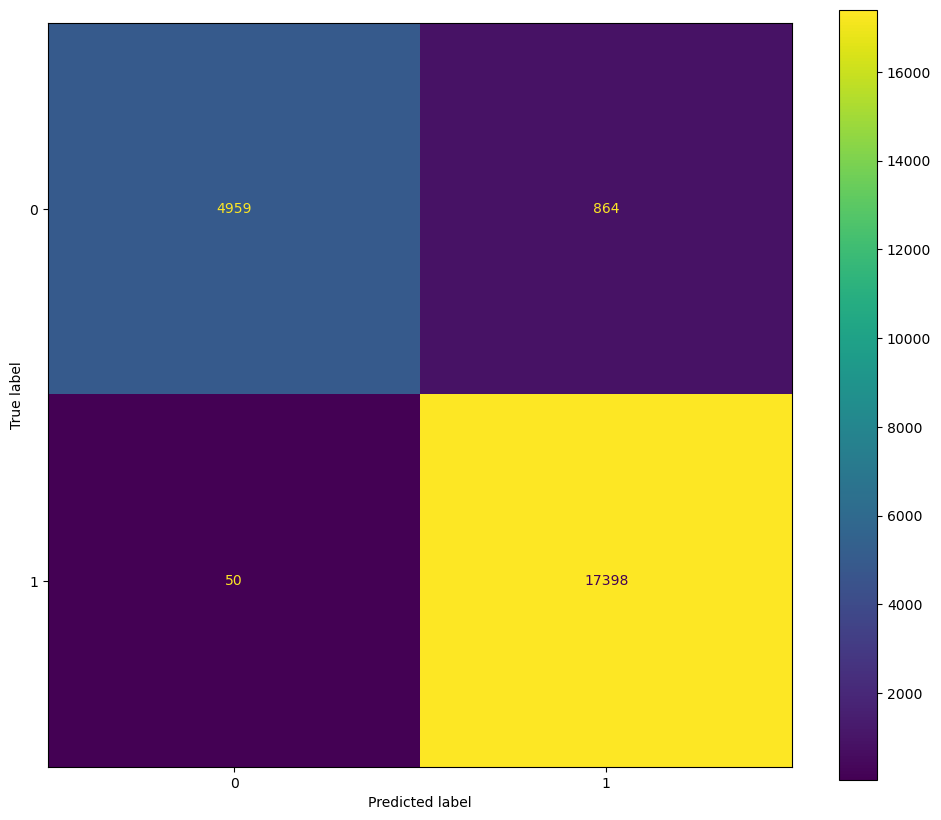

In [51]:
y_pred_e1  = model_e1.predict(test_dataset)
y_pred_val_e1 = [1 if (i > 0.9) else 0 for i in y_pred_e1 ]
cm = confusion_matrix(test_data_labels, y_pred_val_e1)
print(cm)
ConfusionMatrixDisplay(cm).plot()

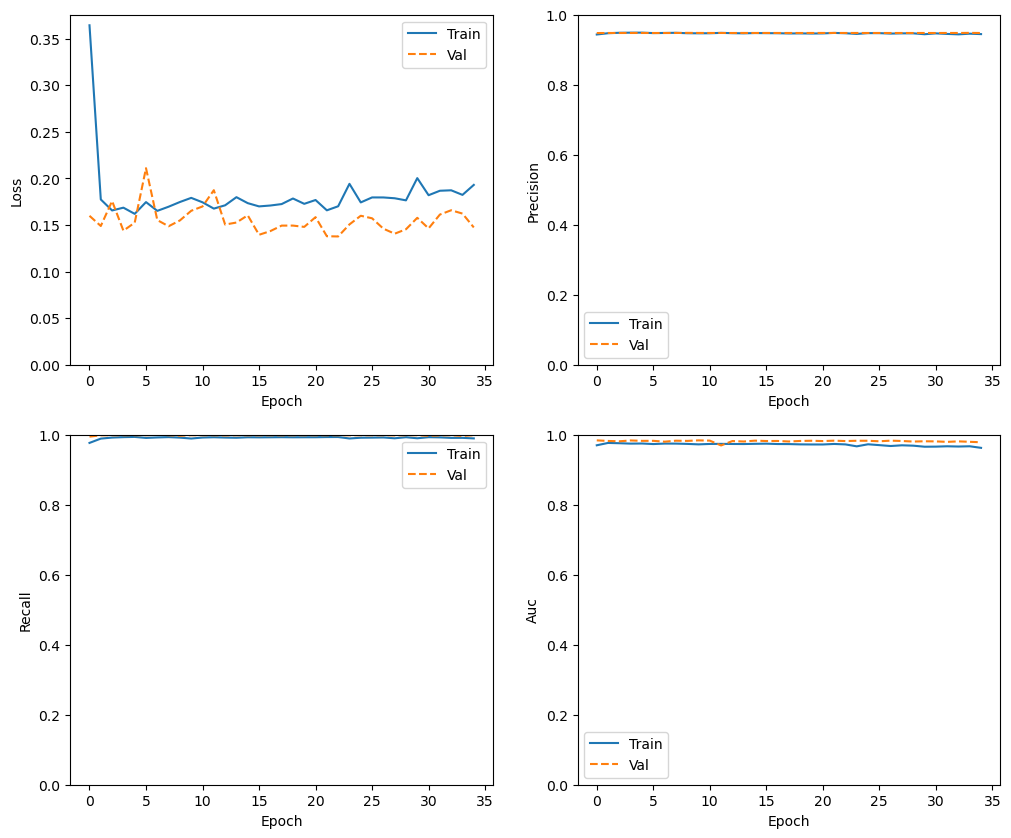

In [52]:
plot_metrics(history_e)

In [53]:
accuracy_a1 = (5728+15536)/(5728+15536+95+1912)
accuracy_b1 = (5778+13215)/(5778+13215+45+4233)
accuracy_c1 = (5767+14984)/(5767+14984+56+2464)
accuracy_d1 = (4987+17056)/(4987+17056+836+392)
accuracy_e1 = (4959+17398)/(4959+17398+864+50)

print(accuracy_a1)
print(accuracy_b1)
print(accuracy_c1)
print(accuracy_d1)
print(accuracy_e1)

0.9137553177774913
0.8161660435735465
0.8917107129044733
0.9472304585105926
0.9607236474582098
